# 1.3a: Sky Map

This notebook visualizes the token space from the origin using spherical coordinates.

## The Question

We've established that many models have a spike of tokens near the origin. But what does this structure look like geometrically? Is it:
- A **spherical shell** (tokens uniformly distributed around the origin)
- A **localized cluster** (tokens concentrated in specific directions)

To answer this, we'll project all tokens onto a spherical coordinate system and create a sky map.

## Coordinate System

We use PCA to find the principal directions of variation in the full token cloud, then use the top 3 principal components as our spherical coordinate basis:

- **North (+Z)**: Points toward north pole (+90° latitude)
- **Meridian (+X)**: Prime meridian (0° longitude)
- **Equinox (+Y)**: Perpendicular to meridian (+90° longitude)

This gives us a natural coordinate system defined by the data itself.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"
# MODEL_NAME = "Qwen2.5-3B-Instruct"
# MODEL_NAME = "Qwen1.5-4B-Chat"
# MODEL_NAME = "Llama-3.2-3B-Instruct"
# MODEL_NAME = "gemma-3-4b-it"
# MODEL_NAME = "granite-4.0-micro"
# MODEL_NAME = "Phi-3-mini-4k-instruct"

# PCA basis selection (1-indexed)
# Negative values flip the direction (e.g., -1 = negative PC1)
NORTH_PC = 2      # North pole (+90° latitude)
MERIDIAN_PC = 1   # Prime meridian (0° longitude)
EQUINOX_PC = 3    # Equinox (+90° longitude)

# Visualization
POINT_SIZE = 1
POINT_ALPHA = 0.5
COLOR = 'steelblue'
FIGSIZE = (16, 8)
DPI = 200

# Density heatmap
ANGULAR_BIN_SIZE = 1.0  # Degrees per bin
DENSITY_SMOOTH = 1.0    # Gaussian smoothing sigma (None = no smoothing)
DENSITY_COLORMAP = 'hot'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from safetensors.torch import load_file
from pathlib import Path

## Load W

In [3]:
# Load W in bfloat16
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]

print(f"Loaded W from {tensor_path}")
print(f"  Shape: {W_bf16.shape}")
print(f"  Dtype: {W_bf16.dtype}")

# Convert to float32 for numerical precision
W = W_bf16.to(torch.float32)
print(f"  Converted to {W.dtype} for analysis")

N, d = W.shape
print(f"\nToken space: {N:,} tokens in {d:,} dimensions")

Loaded W from ../tensors/Qwen3-4B-Instruct-2507/W.safetensors
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  Converted to torch.float32 for analysis

Token space: 151,936 tokens in 2,560 dimensions


## Compute PCA

We'll compute the top 3 principal components to use as our spherical coordinate basis.

In [4]:
print("Computing PCA...")

# Center the data
W_centered = W - W.mean(dim=0)

# Compute covariance matrix (d × d)
# Use centered data: Cov = (1/N) * W_centered^T @ W_centered
print("  Computing covariance matrix...")
cov = (W_centered.T @ W_centered) / N

# Eigendecomposition
print("  Computing eigendecomposition...")
eigenvalues, eigenvectors = torch.linalg.eigh(cov)

# Sort by descending eigenvalue (eigh returns ascending)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"\n✓ PCA computed")
print(f"  Top 3 eigenvalues:")
for i in range(3):
    var_explained = eigenvalues[i] / eigenvalues.sum() * 100
    print(f"    PC{i+1}: λ = {eigenvalues[i]:.6f} ({var_explained:.2f}% variance)")

Computing PCA...
  Computing covariance matrix...
  Computing eigendecomposition...

✓ PCA computed
  Top 3 eigenvalues:
    PC1: λ = 0.010487 (0.94% variance)
    PC2: λ = 0.003178 (0.28% variance)
    PC3: λ = 0.002791 (0.25% variance)


## Define Spherical Basis

In [5]:
def get_pc_vector(pcs, index):
    """Get PC vector by index (1-indexed), with sign flip for negative indices.
    
    Examples:
        1  -> PC1
        -1 -> -PC1 (flipped)
        2  -> PC2
        -3 -> -PC3 (flipped)
    """
    pc_num = abs(index) - 1  # Convert to 0-indexed
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector


# Extract basis vectors
north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print("Spherical coordinate basis:")
print(f"  North (+Z, north pole):    PC{NORTH_PC}")
print(f"  Meridian (+X, 0° lon):     PC{MERIDIAN_PC}")
print(f"  Equinox (+Y, 90° lon):     PC{EQUINOX_PC}")
print()

# Verify orthonormality
print("Verifying orthonormality:")
dot_nm = (north @ meridian).item()
dot_ne = (north @ equinox).item()
dot_me = (meridian @ equinox).item()
print(f"  North · Meridian: {dot_nm:.6e} (should be ~0)")
print(f"  North · Equinox:  {dot_ne:.6e} (should be ~0)")
print(f"  Meridian · Equinox: {dot_me:.6e} (should be ~0)")
print()
print(f"  ||North||:    {torch.norm(north).item():.6f} (should be ~1)")
print(f"  ||Meridian||: {torch.norm(meridian).item():.6f} (should be ~1)")
print(f"  ||Equinox||:  {torch.norm(equinox).item():.6f} (should be ~1)")

Spherical coordinate basis:
  North (+Z, north pole):    PC2
  Meridian (+X, 0° lon):     PC1
  Equinox (+Y, 90° lon):     PC3

Verifying orthonormality:
  North · Meridian: -1.254957e-07 (should be ~0)
  North · Equinox:  2.421439e-08 (should be ~0)
  Meridian · Equinox: 0.000000e+00 (should be ~0)

  ||North||:    1.000000 (should be ~1)
  ||Meridian||: 1.000000 (should be ~1)
  ||Equinox||:  1.000000 (should be ~1)


## Project to Spherical Coordinates

In [6]:
print("Projecting to spherical coordinates...\n")

# Project onto basis vectors
x = W @ meridian  # +X (prime meridian, 0° longitude)
y = W @ equinox   # +Y (equinox, 90° longitude)
z = W @ north     # +Z (north pole, +90° latitude)

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Spherical coordinates
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("✓ Spherical coordinates computed")
print()
print("Latitude:")
print(f"  Range: [{lat_deg.min():.2f}°, {lat_deg.max():.2f}°]")
print(f"  Mean: {lat_deg.mean():.2f}°")
print(f"  Std: {lat_deg.std():.2f}°")
print()
print("Longitude:")
print(f"  Range: [{lon_deg.min():.2f}°, {lon_deg.max():.2f}°]")
print(f"  Mean: {lon_deg.mean():.2f}°")
print(f"  Std: {lon_deg.std():.2f}°")

Projecting to spherical coordinates...

✓ Spherical coordinates computed

Latitude:
  Range: [-84.00°, 89.29°]
  Mean: 16.01°
  Std: 13.74°

Longitude:
  Range: [-180.00°, 179.99°]
  Mean: 1.36°
  Std: 26.79°


## Mollweide Scatter Plot

Creating Mollweide scatter plot...



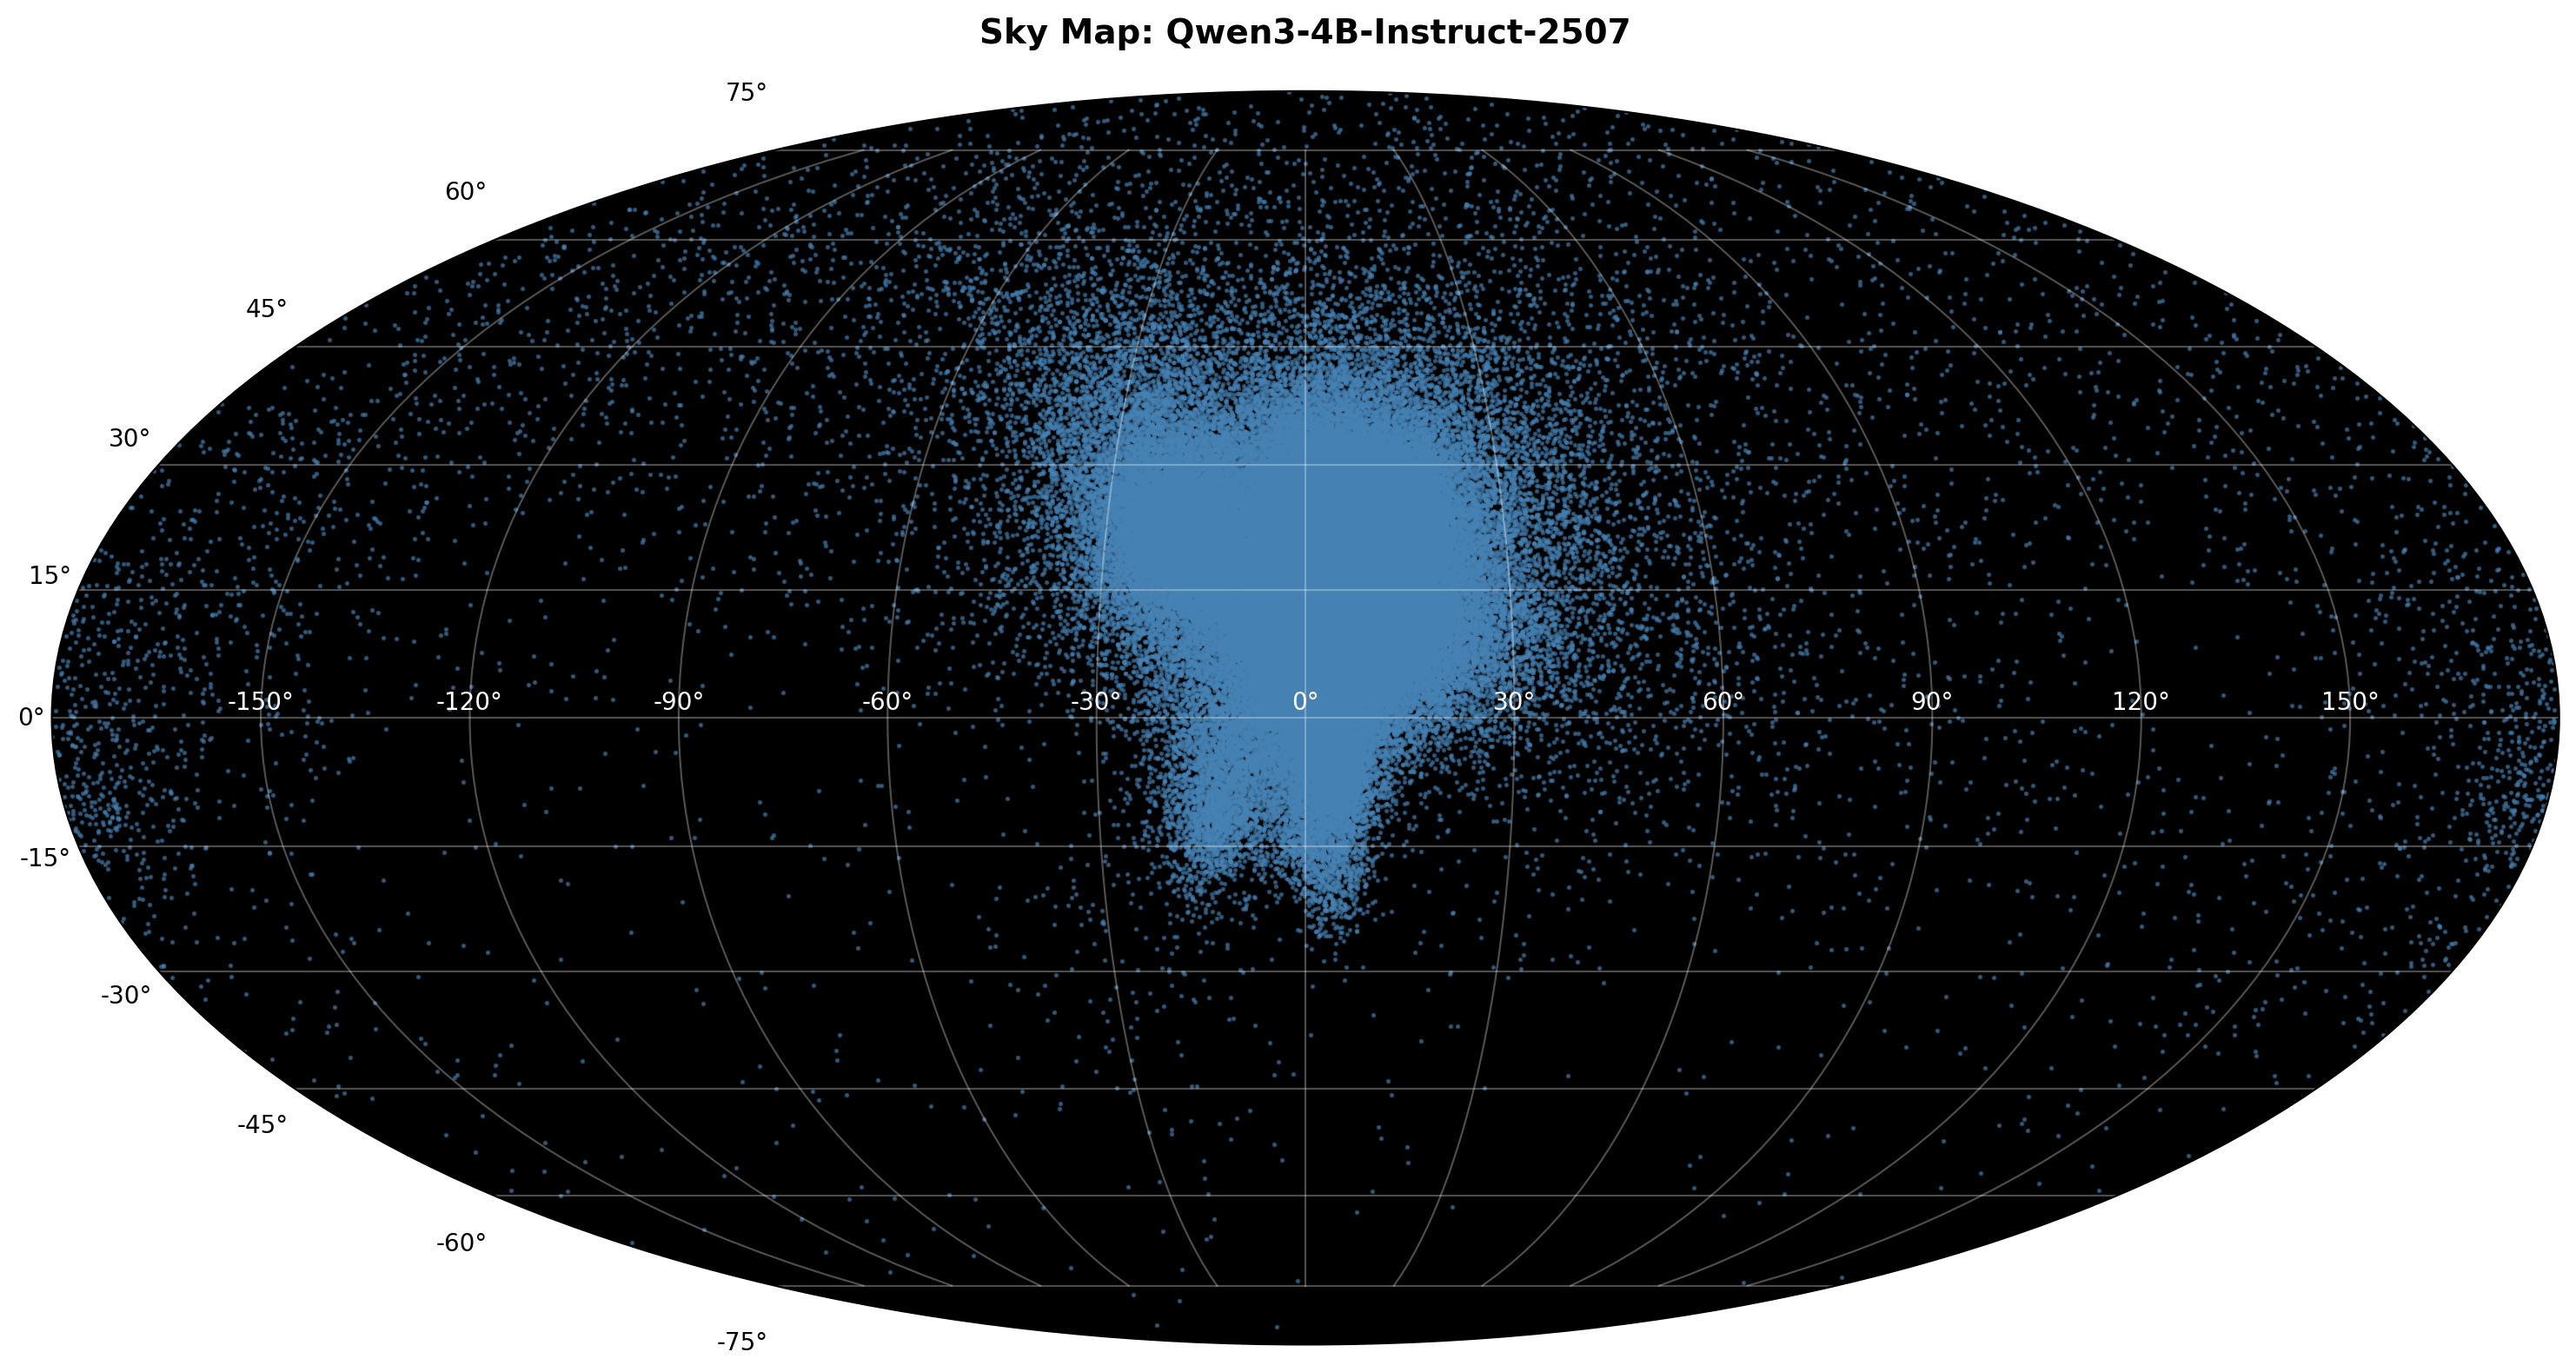

✓ Mollweide scatter plot complete


In [7]:
print("Creating Mollweide scatter plot...\n")

# Convert to numpy and radians for plotting
lon_plot = lon_deg.numpy()
lat_plot = lat_deg.numpy()
lon_rad = np.deg2rad(lon_plot)
lat_rad = np.deg2rad(lat_plot)

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Plot points
ax.scatter(lon_rad, lat_rad, s=POINT_SIZE, alpha=POINT_ALPHA, c=COLOR, rasterized=True)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Sky Map: {MODEL_NAME}', color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide scatter plot complete")

## Mollweide Density Heatmap

Creating Mollweide density heatmap...

Density grid: 360 × 180 bins
  Angular bin size: 1.0°

Applied Gaussian smoothing (σ = 1.0)
Density statistics:
  Max density: 439.1 tokens per bin
  Mean density: 2.3 tokens per bin



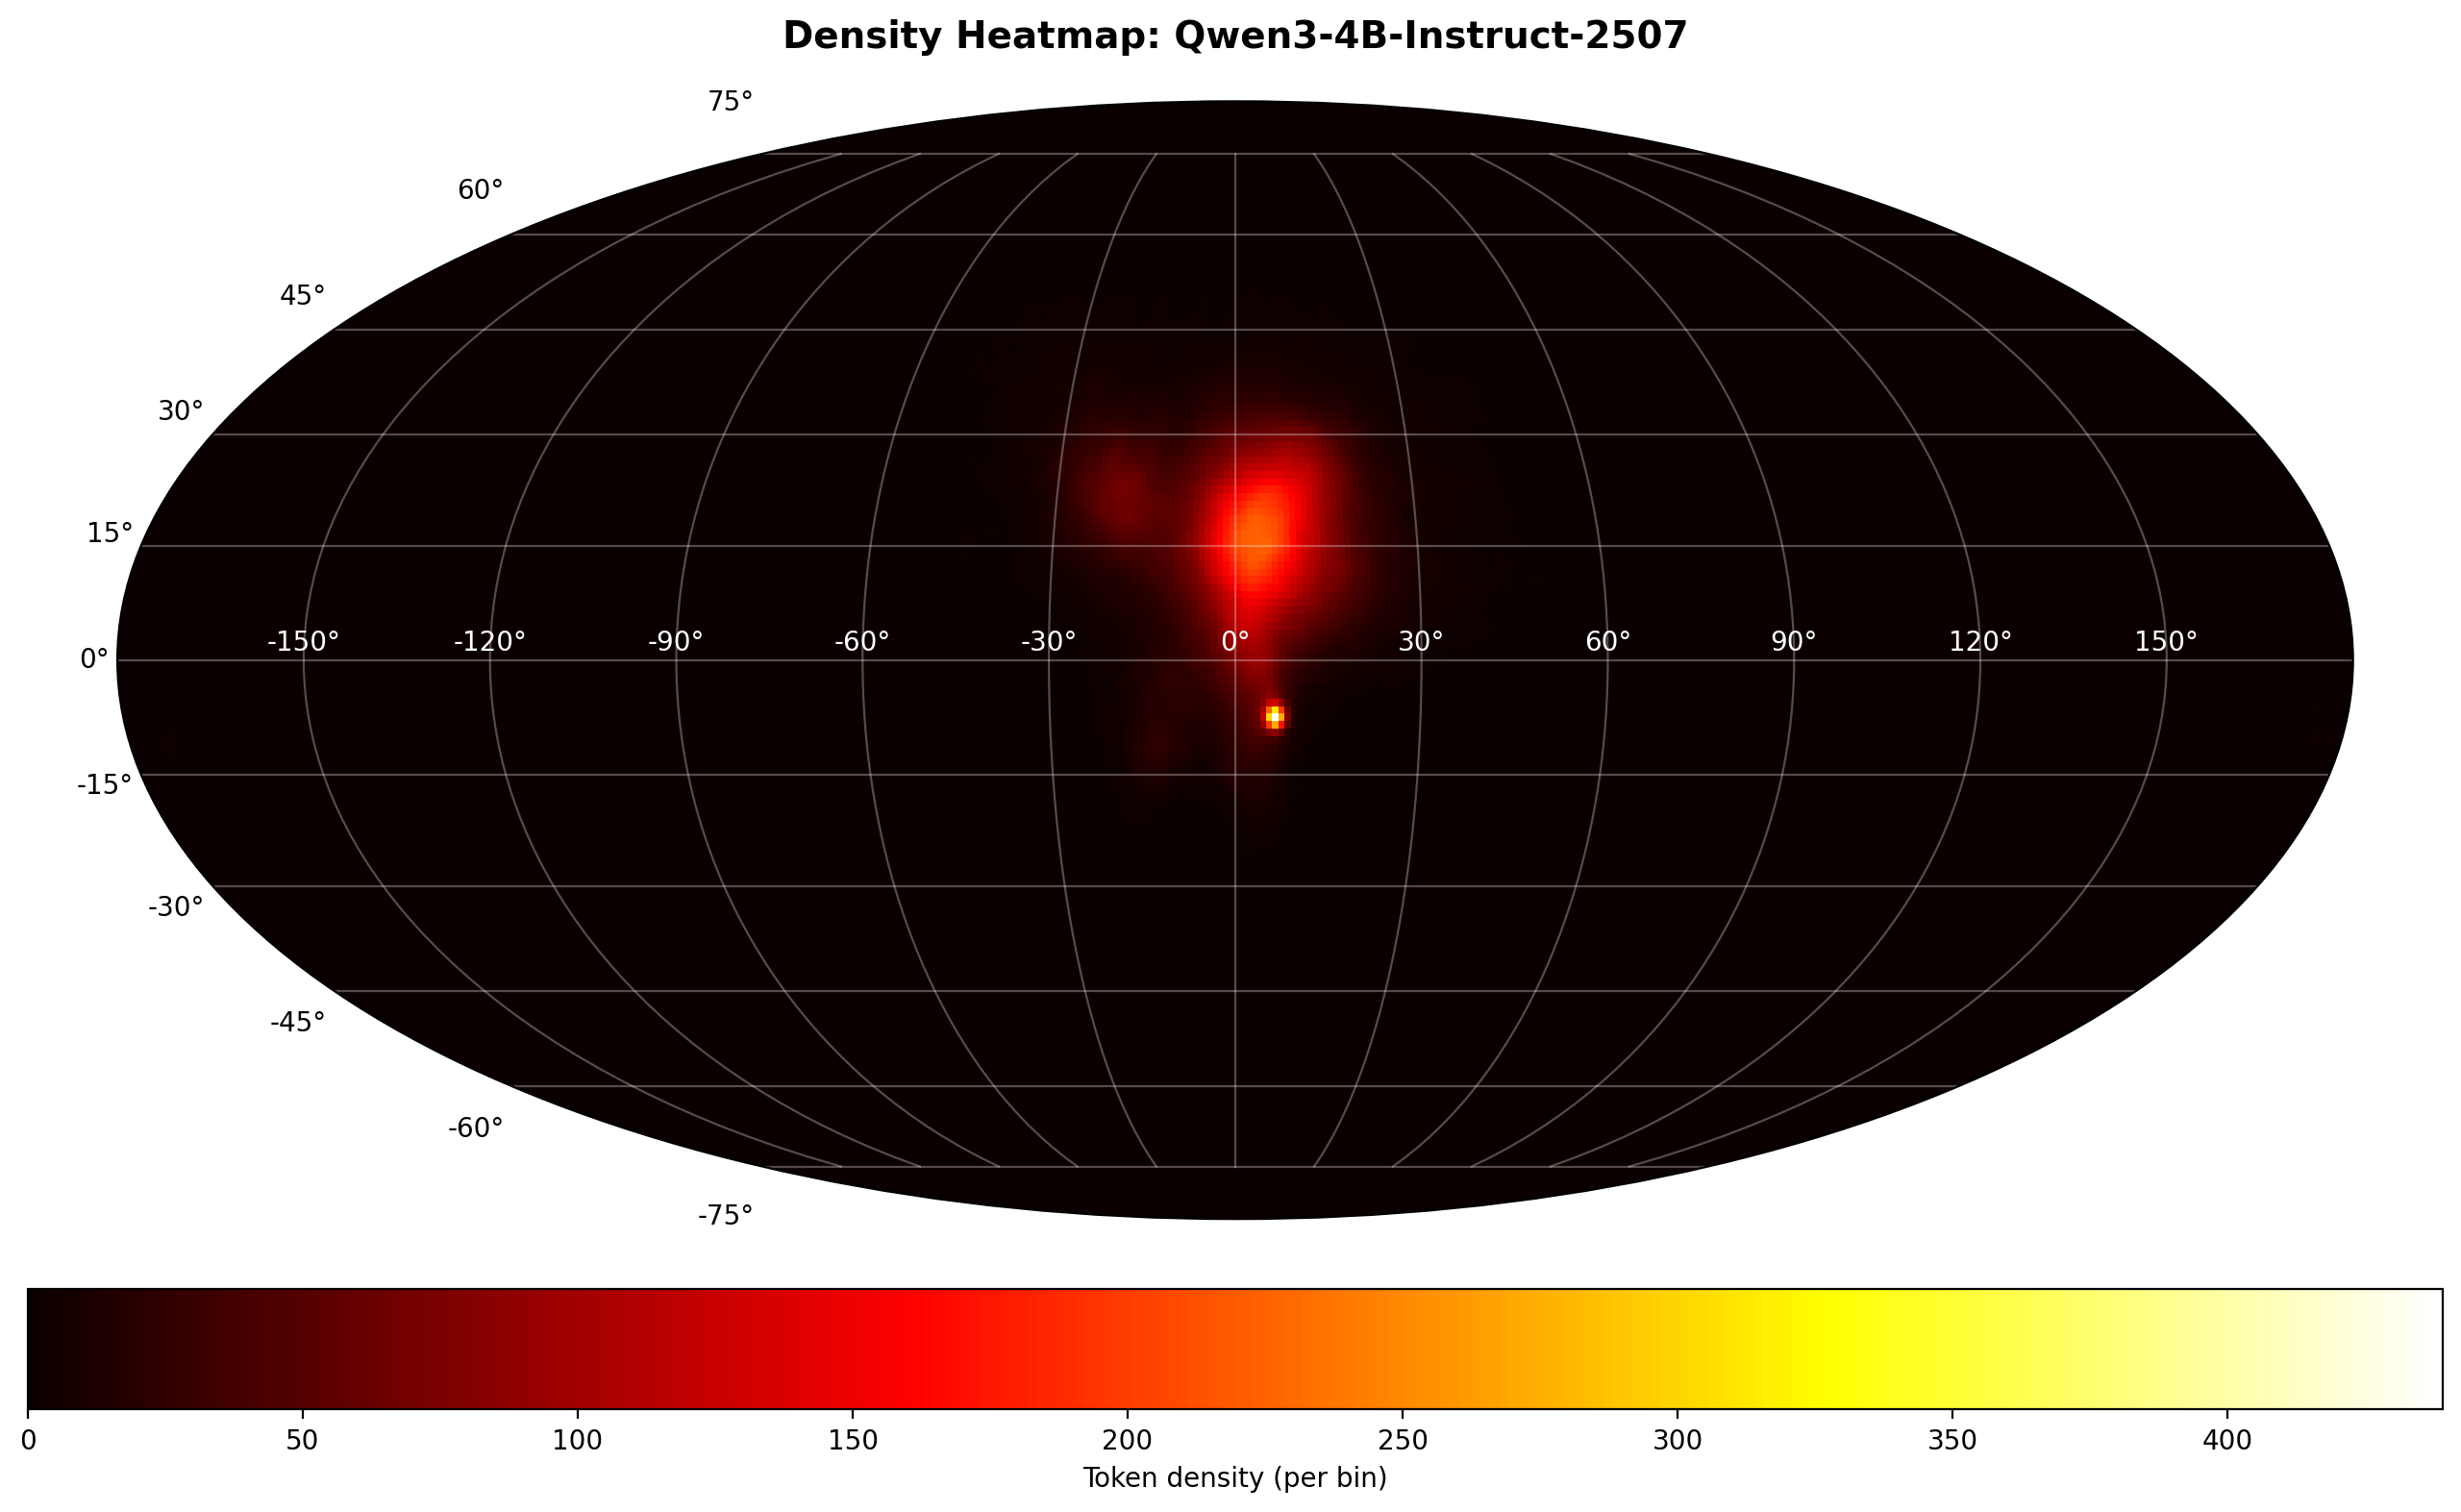

✓ Mollweide density heatmap complete


In [8]:
print("Creating Mollweide density heatmap...\n")

# Compute bin counts
n_lon_bins = int(np.ceil(360.0 / ANGULAR_BIN_SIZE))
n_lat_bins = int(np.ceil(180.0 / ANGULAR_BIN_SIZE))

print(f"Density grid: {n_lon_bins} × {n_lat_bins} bins")
print(f"  Angular bin size: {ANGULAR_BIN_SIZE}°")
print()

# Create 2D histogram
hist, lon_edges, lat_edges = np.histogram2d(
    lon_plot, lat_plot,
    bins=[n_lon_bins, n_lat_bins],
    range=[[-180, 180], [-90, 90]]
)

# Apply Gaussian smoothing if requested
if DENSITY_SMOOTH is not None:
    hist = gaussian_filter(hist, sigma=DENSITY_SMOOTH)
    print(f"Applied Gaussian smoothing (σ = {DENSITY_SMOOTH})")

print(f"Density statistics:")
print(f"  Max density: {hist.max():.1f} tokens per bin")
print(f"  Mean density: {hist.mean():.1f} tokens per bin")
print()

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Bin centers for plotting
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
lon_grid_rad = np.deg2rad(lon_grid)
lat_grid_rad = np.deg2rad(lat_grid)

# Plot heatmap
mesh = ax.pcolormesh(lon_grid_rad, lat_grid_rad, hist.T,
                     cmap=DENSITY_COLORMAP,
                     shading='auto', rasterized=True)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Token density (per bin)', color='black', fontsize=10)
cbar.ax.tick_params(colors='black')

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Density Heatmap: {MODEL_NAME}', color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide density heatmap complete")

## Observations

Look for:
- **Uniform distribution**: Tokens spread evenly across the sky → spherical shell structure
- **Concentrated regions**: High-density areas in specific directions → localized clusters
- **Empty regions**: Areas with few or no tokens → asymmetric structure

If tokens form a spherical shell, we'd expect roughly uniform density everywhere. If they cluster, we'll see distinct high-density regions and voids.